In [95]:
import datetime as dt
import pandas as pd
import numpy as np
import alphalens as al
import scipy.stats as ss
from scipy.optimize import minimize
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')
style.use('seaborn-poster')

mod_path = '/Users/richard.wuebker/Projects/price_data_utils'
if mod_path not in sys.path:
    sys.path.append(mod_path)
    
from data_loader import DataLoader
from mp_historical_prices import HistoricalPrices

In [2]:
dl = DataLoader(prices_dir='../../price_data_utils/prices', info_dir='../../price_data_utils/info', 
                analysis_date_str='2019-07-26', cached_dir='../../price_data_utils/cached')
dl.load_data()

Prediction Date: 2019-07-30


In [3]:
data = dl.data
data.head()

,mkt_cap,beta,book_value,sector,eps,month_ago,year_ago,prev_date,analysis_date,trade_date,pred_date,volume
ticker,,,,,,,,,,,,
CSCO,241989664768,1.028849,36804000000,Technology,2.882000,56.245041,42.669865,56.619999,56.529999,56.930000,56.470001,15243000.0
SITC,2462647552,0.870377,1524945000,Real Estate,0.922000,12.890000,NaN,13.640000,13.640000,13.990000,14.130000,1154157.0
UAL,23986143232,1.278593,10320000000,Industrials,9.838000,85.330002,82.790001,93.930000,93.360001,93.440002,93.930000,1684800.0
TROW,27137085440,1.029243,6579100000,Financial Services,7.945001,106.889999,116.327202,113.919998,115.199997,114.959999,115.360001,1165300.0
ISRG,60810940416,1.289684,7265300000,Healthcare,10.129000,513.719971,519.280029,531.690002,527.630005,529.609985,531.640015,459100.0


In [4]:
hp = HistoricalPrices(prices_dir='../../price_data_utils/prices', 
                      cached_dir='../../price_data_utils/cached',
                      date_str='2019-08-02')
hp.get_prices()
prices = hp.prices
prices.head()

,High,Low,Open,Close,Volume,Adj Close,ticker
Date,,,,,,,
2017-05-12,21.299999,20.270000,21.250000,21.10,10933700.0,21.10,GDI
2017-05-15,22.299999,21.010000,21.010000,22.02,3487300.0,22.02,GDI
2017-05-16,22.410000,22.049999,22.190001,22.10,1289300.0,22.10,GDI
2017-05-17,22.510000,21.670000,22.150000,22.10,1583700.0,22.10,GDI
2017-05-18,23.629999,21.980000,22.190001,22.50,4075200.0,22.50,GDI


In [87]:
pivoted_prices = prices.reset_index().pivot(index='Date', 
                                            columns='ticker', 
                                            values='Adj Close').loc['2017-01-01':'2017-12-31',:].dropna(axis=1)
pivoted_prices.head()

ticker,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACC,...,YUMC,Z,ZAYO,ZBH,ZBRA,ZEN,ZG,ZION,ZNGA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,45.458351,28.83,45.210602,169.822006,111.709831,55.652992,79.012138,112.360001,37.014076,43.978065,...,25.735418,37.220001,33.540001,102.037155,86.250000,22.129999,37.380001,41.394863,2.65,52.623463
2017-01-04,46.054810,30.26,45.601189,171.215622,111.584778,56.437721,80.972862,115.739998,37.307915,45.176643,...,26.108110,37.090000,32.450001,102.975266,87.029999,22.230000,37.299999,41.989223,2.69,53.134083
2017-01-05,45.507244,30.65,44.810249,171.096146,112.152229,56.865753,80.035553,114.809998,37.630192,45.401947,...,26.470995,36.419998,30.379999,103.636887,84.750000,22.340000,36.810001,41.308586,2.65,52.957333
2017-01-06,46.925068,30.68,45.122715,168.856430,113.402542,56.883591,81.106766,115.419998,38.653877,45.618229,...,25.656956,36.700001,30.750000,103.646767,85.959999,22.469999,37.139999,41.577003,2.72,53.124260
2017-01-09,47.071735,29.48,45.972256,168.756897,114.441246,57.258114,81.757156,117.110001,38.615971,45.122574,...,25.549070,36.950001,30.969999,105.661240,85.970001,23.190001,37.220001,41.126446,2.66,52.976974


In [88]:
p = pivoted_prices.loc[:,['AAPL', 'CSCO', 'IBM', 'AMZN']]
print(p.shape)
p.head()

(251, 4)


ticker,AAPL,CSCO,IBM,AMZN
Date,,,,
2017-01-03,111.709831,28.040636,150.422272,753.669983
2017-01-04,111.584778,27.873951,152.284653,757.179993
2017-01-05,112.152229,27.938770,151.780807,780.450012
2017-01-06,113.402542,27.994335,152.527573,795.989990
2017-01-09,114.441246,27.948032,150.836121,796.919983


In [89]:
rets = p.pct_change()
rets.head()

ticker,AAPL,CSCO,IBM,AMZN
Date,,,,
2017-01-03,NaN,NaN,NaN,NaN
2017-01-04,-0.001119,-0.005944,0.012381,0.004657
2017-01-05,0.005085,0.002325,-0.003309,0.030732
2017-01-06,0.011148,0.001989,0.004920,0.019912
2017-01-09,0.009159,-0.001654,-0.011089,0.001168


In [90]:
np.random.seed(101)

num_ports = 5000
all_weights = np.zeros((num_ports, len(rets.columns)))
ret_arr = np.zeros(num_ports)
std_arr = np.zeros(num_ports)
sr_arr = np.zeros(num_ports)

for ix in range(num_ports):
    weights = np.random.random(len(rets.columns))
    reb_weights = weights / np.sum(weights)
    all_weights[ix,:] = reb_weights
    
    ret_arr[ix] = np.sum((rets.mean() * reb_weights) * 252)
    std_arr[ix] = np.sqrt(np.dot(reb_weights.T, np.dot(rets.cov() * 252, reb_weights)))
    sr_arr[ix] = ret_arr[ix]/std_arr[ix]

In [91]:
print('max sharpe: ', sr_arr.max())
max_sharpe_ix = sr_arr.argmax()
max_sr_ret = ret_arr[max_sharpe_ix]
max_sr_std = std_arr[max_sharpe_ix]

max sharpe:  2.894688283095566


In [92]:
all_weights[1616,:]

array([0.47205837, 0.51425067, 0.01118475, 0.00250621])

In [93]:
rets.mean()*252

ticker
AAPL    0.411191
CSCO    0.276143
IBM    -0.036145
AMZN    0.464567
dtype: float64

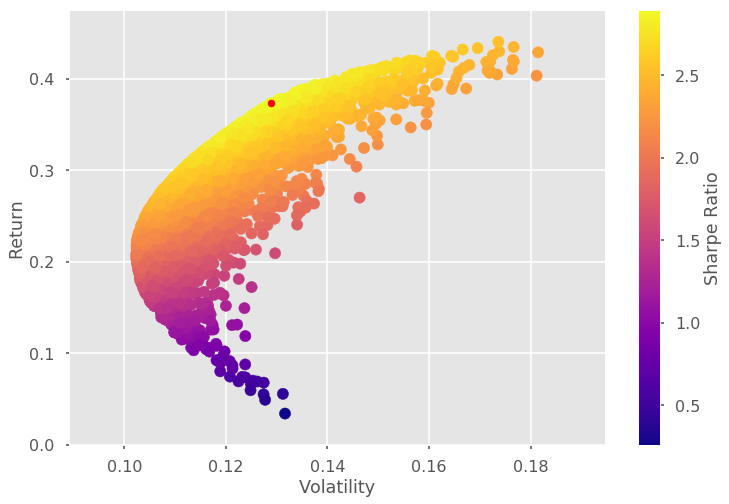

In [94]:
plt.figure(figsize=(12,8))
plt.scatter(std_arr, ret_arr, c=sr_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_std, max_sr_ret, c='red', s=50)

# Adding the Efficient Frontier

In [97]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(rets.mean()*weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(rets.cov()*252, weights)))
    sr = ret / std
    return np.array([ret, std, sr])

In [98]:
# our function to minimize:
def neg_sharpe(weigths):
    return get_ret_vol_sr(weights)[2] * -1

In [99]:
def check_sum(weights):
    # return 0 if sum of weights is 1
    return np.sum(weights) - 1

In [100]:
cons = ({'type': 'eq', 'fun': check_sum}) # should return 0 for correct constraint

In [101]:
bounds = ((0,1), (0,1), (0,1), (0,1))
init_guess = [0.25, 0.25, 0.25, 0.25]

In [103]:
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
opt_results

     fun: -2.772897209081562
     jac: array([0., 0., 0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 6
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0.25, 0.25, 0.25, 0.25])

In [104]:
get_ret_vol_sr(opt_results.x)

array([0.27893917, 0.10926   , 2.55298529])

In [113]:
frontier_y = np.linspace(0, 0.45, 100)

In [114]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [115]:
frontier_vol = []

for pos_ret in frontier_y:
    cons = ({'type':'eq', 'fun': check_sum}, {'type': 'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - pos_ret})
    result = minimize(minimize_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_vol.append(result['fun'])

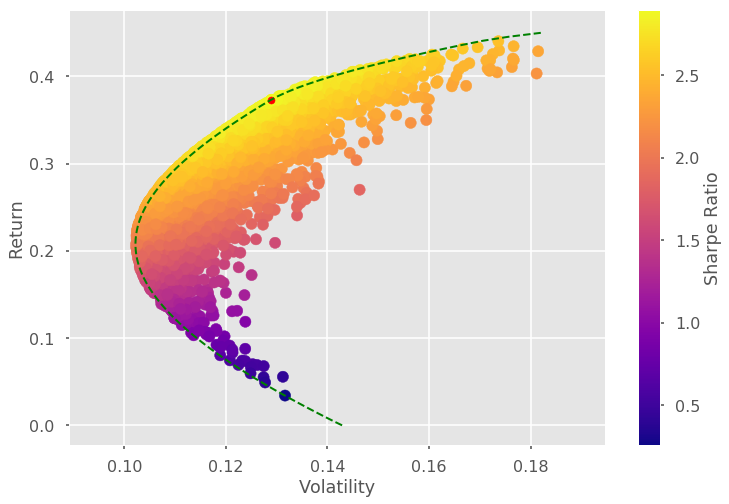

In [116]:
plt.figure(figsize=(12,8))
plt.scatter(std_arr, ret_arr, c=sr_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_std, max_sr_ret, c='red', s=50)

plt.plot(frontier_vol, frontier_y, 'g--', lw=2)